## Dependances

In [ ]:
import cv2 
import argparse
import sys
import os
import json
import time
import random
import datetime
import argparse
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import pandas as pd


import datasets
import util.misc as utils
from models import build_model
import datasets.transforms as T
from torchvision.transforms import v2
from datasets import build_dataset
from engine import evaluate, train_one_epoch
from pathlib import Path
from torchsampler import ImbalancedDatasetSampler
from PIL import Image
from IPython.display import clear_output

# Local dep
project_dir = '/data/konrad/workspace'
sys.path.insert(0, project_dir)

from helpers.datasets import CalfFaceDataset
from helpers.helpers import get_indices, load_face_data, uniform_sample_with_values
from helpers.trainers import plot_metrics


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Utilitaires

In [ ]:
class CalfCenterFaceDataset(Dataset):
    # def __init__(self, df, image_dir, bbox_size = 800, transform=None):
    def __init__(self, df, bbox_size = 800, transform=None):
        self.data_frame = df
        self.transform = transform
        # self.image_dir = image_dir
        self.bbox_size = bbox_size
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.loc[idx]
        img_path = self.data_frame.loc[idx, "path"]  
        # img_path = self.image_dir + '/' + img_name
        image = Image.open(img_path)
        label = self.data_frame.loc[idx, "target"]

        xmin = row['x_min']
        ymin = row['y_min']
        xmax = row['x_max']
        ymax = row['y_max']
        
        # Calculate the width and height of the bounding box
        bbox_width = xmax - xmin
        bbox_height = ymax - ymin
        
        # Calculate the center of the first bounding box
        center_x = xmin + bbox_width / 2
        center_y = ymin + bbox_height / 2
        
        # Define the width and height of the second bounding box
        second_bbox_width = self.bbox_size
        second_bbox_height = self.bbox_size
        
        # Calculate the top-left corner of the second bounding box
        second_xmin = center_x - second_bbox_width / 2
        second_ymin = center_y - second_bbox_height / 2

        # Open the image

        # Crop the first bounding box from the image
        bbox_cropped_image = image.crop((xmin, ymin, xmax, ymax))
        
        # Resize the first cropped image to 800x800
        # first_resized_image = first_cropped_image.resize((self.bbox_size, self.bbox_size))
        
        # Crop the second bounding box from the image
        # img = Image.fromarray(img.cpu().permute(1, 2, 0).numpy())
        image = image.crop((second_xmin, second_ymin, second_xmin + second_bbox_width, second_ymin + second_bbox_height))

        # img = v2.ToTensor()(img)
        image = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(image)
        bbox_cropped_image = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(bbox_cropped_image)
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'bbox': (xmin, ymin, xmax, ymax), 'label': label}
        image = image.to(device)
        label = torch.tensor(label).to(device)

        sample = {"row_image":bbox_cropped_image,  'image': image, 'label': label, "img_path":img_path }
        return sample

class ImageDataset(Dataset):
    def __init__(self, dataset, bbox_size = 800, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.bbox_size = bbox_size

    def __getitem__(self, index):
        row = self.dataset[index]
        img = row["row_image"]
        img_path = row["img_path"]
        
        if self.transform:
            img = self.transform(img)

        img = img.to(device)
        target = {}
        target["file_name"] = [str(row["img_path"])]
        target["image_label"] = torch.tensor([row["label"]], dtype=torch.int64)  # Set the target label as needed

        return img, target

    def __len__(self):
        return len(self.dataset)

    def get_labels(self):
        return self.dataset.data_frame["label"]

In [ ]:
@torch.no_grad()
def predicted_class(output, topk=(1,)):
    query_logits = output['query_logits']
    batch_size = query_logits.size(0)
    
    maxk = min(max(topk), query_logits.size(1))
    _, pred = query_logits.topk(maxk, dim=1, largest=True, sorted=True)
    return pred

def predicted_bin_class(output):
    query_logits = output['query_logits']
    probs = torch.sigmoid(query_logits)
    
        # Assuming the threshold of 0.5 to decide the predicted class
    pred = (probs >= 0.5).long().squeeze()
    return pred

def get_class_name(number):
    modified_name = id2label[number]
    return modified_name

def SuperImposeHeatmap(attention, input_image):
    alpha=0.5
    avg_heatmap_resized = cv2.resize(attention, (input_image.shape[1], input_image.shape[0]), interpolation=cv2.INTER_CUBIC)
    avg_normalized_heatmap = (avg_heatmap_resized - np.min(avg_heatmap_resized)) / (np.max(avg_heatmap_resized) - np.min(avg_heatmap_resized))
    heatmap = (avg_normalized_heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.medianBlur(heatmap,15)
    heatmap =  cv2.GaussianBlur(heatmap, (15, 15), 0)
    result = (input_image *alpha  + heatmap * (1-alpha)).astype(np.uint8)
    return result


def visualization(args, input_image, query_index, attention_scores, encoder_output):

    attention_score = attention_scores[5, :, :, :, :] # sixth layer of the decoder
    attention_score_pred_query = attention_score[:, :, query_index, :] # query corresponding to predicted class 

    # Load and resize the original image
    # input_image = cv2.imread(image_path)
    input_image = input_image.permute(1, 2, 0).numpy()
    
    np_array = input_image

    # If the values are in the range [0, 1], convert them to [0, 255]
    if np_array.max() <= 1.0:
        np_array = (np_array * 255).astype(np.uint8)

    # If the image is in the range [0, 255] but not in uint8 format, convert to uint8
    elif np_array.dtype != np.uint8:
        np_array = np_array.astype(np.uint8)

    # Convert RGB to BGR format for OpenCV
    input_image = cv2.cvtColor(np_array, cv2.COLOR_RGB2BGR)

    input_image = cv2.resize(input_image, (0, 0), fx=0.8, fy=0.8)

    # Create a subplot grid for the original image and visualizations
    num_heads = attention_score_pred_query.shape[1] + 1  
    rows = 1
    cols = num_heads // rows

    # Plot the original image
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes[0].imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')

    for head_index in range(attention_score_pred_query.shape[1]):
        heatmap_head = attention_score_pred_query[:, head_index, :].reshape(encoder_output.shape[2], encoder_output.shape[3]).detach().cpu().numpy()
        result = SuperImposeHeatmap(heatmap_head, input_image)

        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1:
            ax = axes[head_index + 1]
        elif cols == 1:
            ax = axes[head_index + 1]
        else:
            ax = axes[(head_index + 1) // cols, (head_index + 1) % cols]

        ax.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        ax.axis('off')

    plt.tight_layout()
    plt.show()



def load_model(args, model):
    checkpoint = torch.load(args.resume, map_location='cpu')
    model.load_state_dict(checkpoint['model'])
    return model


In [ ]:
def get_args_parser(training = False, epochs = 10, batch_size = 12, num_labels=3):
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--batch_size', default=batch_size, type=int)

    if training:
        parser.add_argument('--lr', default=5.00e-5, type=float) 
        parser.add_argument('--lr_backbone', default=0, type=float) 
        parser.add_argument('--min_lr', default=1.00e-6, type=float) 
        parser.add_argument('--weight_decay', default=1e-6, type=float)
        parser.add_argument('--epochs', default=epochs, type=int) 
        parser.add_argument('--lr_drop', default=80, type=int) 
        parser.add_argument('--lr_scheduler', default="StepLR", type=str, choices=["StepLR", "CosineAnnealingLR"])
        parser.add_argument('--clip_max_norm', default=0.1, type=float,
                            help='gradient clipping max norm')

    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")
    if training:
        parser.add_argument('--finetune', default='intr_checkpoint_cub_detr_r50.pth',
                        help='resume from checkpoint')
    else:
        parser.add_argument('--resume', default=ROOT_DIR + '/repos/intr/output/calf_face/output_sub/checkpoint.pth',
                        help='resume from checkpoint')
    
    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer") #default=0.1
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=num_labels, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # # * Dataset parameters
    parser.add_argument('--dataset_name', default='gen_calf_face') 
    parser.add_argument('--output_dir', default=ROOT_DIR + '/training_log/intr_output',
                        help='path where to save, empty for no saving')
    parser.add_argument('--output_sub_dir', default='output_sub')

    # * Device parameters
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    
    return parser



def plot_metrics(train_losses, train_accuracies, train_accuracies_std, train_recalls, train_f1_scores, valid_losses, valid_accuracies, valid_recalls, valid_f1_scores):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, valid_losses, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train')
    plt.plot(epochs, train_accuracies_std, label='Train - Std')
    plt.plot(epochs, valid_accuracies, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Plot training and validation recalls
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_recalls, label='Train')
    plt.plot(epochs, valid_recalls, label='Validation')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()
    
    # Plot training and validation F1 scores
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_f1_scores, label='Train')
    plt.plot(epochs, valid_f1_scores, label='Validation')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

## Setup

In [ ]:
ROOT_DIR = "/data/konrad/workspace"
DATA_FILE = ROOT_DIR + "/CompleteDatasetNormalFace/Face_annotations.csv"
IMAGE_DIR = ROOT_DIR + "/CompleteDatasetNormalFace"

# df, labels, label2id, id2label = load_face_data(DATA_FILE, IMAGE_DIR)

In [ ]:
frame = 10
step = 0
# root_dir = ROOT_DIR + f"/datasets/mixed_{frame}s_b{step}s"
# root_dir = f"/data/data_calves/konrad/mixed_{frame}s_b{step}s"
train_df = pd.read_csv(ROOT_DIR + f'/csv_files/splt_train_image_{frame}s_b{step}s_extracted_metadata.csv', index_col=False)
valid_df = pd.read_csv(ROOT_DIR + f'/csv_files/splt_test_image_{frame}s_b{step}s_extracted_metadata.csv', index_col=False)
test_df = pd.read_csv(ROOT_DIR + f'/csv_files/splt_val_image_{frame}s_b{step}s_extracted_metadata.csv', index_col=False)

label_col = "bilabel"

# train_df = train_df[~ (train_df[label_col] == "Diarrhé, Pneumonie")]
# valid_df = valid_df[~ (valid_df[label_col] == "Diarrhé, Pneumonie")]
# test_df = test_df[~ (test_df[label_col] == "Diarrhé, Pneumonie")]
# label_col = "label"

labels = train_df[label_col].unique()
label2id = {l:i for i, l in enumerate(labels)}
id2label = {i:l for i, l in enumerate(labels)}

# num_labels = len(labels)
num_labels = 1
train_df['target'] = train_df.apply(lambda row: label2id[row[label_col]], axis=1)
test_df['target'] = test_df.apply(lambda row: label2id[row[label_col]], axis=1)
valid_df['target'] = valid_df.apply(lambda row: label2id[row[label_col]], axis=1)

In [ ]:
IMAGE_SIZE = 400
data_mean_std = {
    "cub": (
        torch.tensor([0.485, 0.456, 0.406]),
        torch.tensor([0.229, 0.224, 0.225]),
    ),
}
mean, std = data_mean_std["cub"]

train_transform = v2.Compose([
    v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.ColorJitter(brightness=.5, hue=.3),
    # v2.RandomPosterize(bits=2),
    # v2.RandomEqualize(),
    # v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    # v2.AutoAugment(v2.AutoAugmentPolicy.SVHN),
    # v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=mean),
])

test_transform = v2.Compose([
    v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    # v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

train_dataset = CalfCenterFaceDataset(train_df)
test_dataset = CalfCenterFaceDataset(test_df, transform=None)
valid_dataset = CalfCenterFaceDataset(valid_df, transform=None)

In [ ]:
class_counts = valid_df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Classes in Validation set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
class_counts = train_df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Classes in Training set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Training

In [ ]:
args_parser = get_args_parser(training=True, epochs = 10, batch_size = 12, num_labels=num_labels)
parser = argparse.ArgumentParser('INTR training and evaluation script', parents=[args_parser])
args = parser.parse_args([])
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
best_valid_loss = float('inf')

model, criterion = build_model(args)
model.to(device)
model_without_ddp = model

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

param_dicts = [
    {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
    {
        "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
        "lr": args.lr_backbone,
    },
]


if args.lr_scheduler=="StepLR":
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                  weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

if args.lr_scheduler=="CosineAnnealingLR":
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr, 
                                weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=args.min_lr)

# dataset_train = ImageDataset(train_dataset)
# dataset_val = ImageDataset(test_dataset)

dataset_train = ImageDataset(train_dataset, transform=train_transform)
dataset_val = ImageDataset(test_dataset, transform=test_transform)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, args.batch_size, drop_last=True)

data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                             drop_last=False, collate_fn=utils.collate_fn)

#   We create output directories to store results
output_dir = Path(args.output_dir)
if not os.path.exists(os.path.join(output_dir, args.dataset_name)):
    os.makedirs(os.path.join(output_dir, args.dataset_name), exist_ok=True)
if not os.path.exists(os.path.join(output_dir, args.dataset_name, args.output_sub_dir)):
    os.makedirs(os.path.join(output_dir, args.dataset_name, args.output_sub_dir), exist_ok=True)

if args.finetune:
    if args.finetune.startswith('https'):
        checkpoint = torch.hub.load_state_dict_from_url(
            args.finetune, map_location='cpu', check_hash=True)
    else:
        checkpoint = torch.load(args.finetune, map_location='cpu')
    state_dict = checkpoint['model']

    existing_num_queries = state_dict['query_embed.weight'].shape[0]

    if args.num_queries<existing_num_queries:
        new_query_embeds = state_dict['query_embed.weight'][:args.num_queries, :]
        state_dict['query_embed.weight'] = new_query_embeds
    
    model_without_ddp.load_state_dict(state_dict)

    for param in model_without_ddp.parameters():
        param.requires_grad = True
    model_without_ddp.to(device)

train_losses, train_accuracies, train_accuracies_std, train_recalls, train_f1_scores = [], [], [], [], []
valid_losses, valid_accuracies, valid_recalls, valid_f1_scores = [], [], [], []

print("Start training")
start_time = time.time()
for epoch in range(args.epochs):

    train_stats = train_one_epoch(
        model, criterion, data_loader_train, optimizer, device, epoch,
        args.clip_max_norm)
    print("\n")

    lr_scheduler.step()

    test_stats = evaluate(
        model, criterion,  data_loader_val, device, args.output_dir
    )
    valid_loss = test_stats["loss"]
    
    if args.output_dir:
        checkpoint_paths = [output_dir / args.dataset_name / args.output_sub_dir/ 'checkpoint.pth']

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            checkpoint_paths.append(output_dir / args.dataset_name / args.output_sub_dir / f'best_checkpoint.pth')

        if (epoch + 1) % args.lr_drop == 0 or (epoch + 1)==args.epochs:
            checkpoint_paths.append(output_dir / args.dataset_name / args.output_sub_dir / f'checkpoint{epoch:04}.pth')
            
        for checkpoint_path in checkpoint_paths:
            utils.save_on_master({
                'model': model_without_ddp.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'args': args,
            }, checkpoint_path)

    train_losses.append(train_stats["loss"])
    train_accuracies.append(train_stats["acc1"])
    train_accuracies_std.append(train_stats["acc_std"])
    train_recalls.append(train_stats["recall"])
    train_f1_scores.append(train_stats["f1"])

    valid_losses.append(test_stats["loss"])
    valid_accuracies.append(test_stats["precision"])
    valid_recalls.append(test_stats["recall"])
    valid_f1_scores.append(test_stats["f1"])

    print("-" * 30)
    print("\n\n")

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
clear_output()
print('Training time {}'.format(total_time_str))

## Analyse 

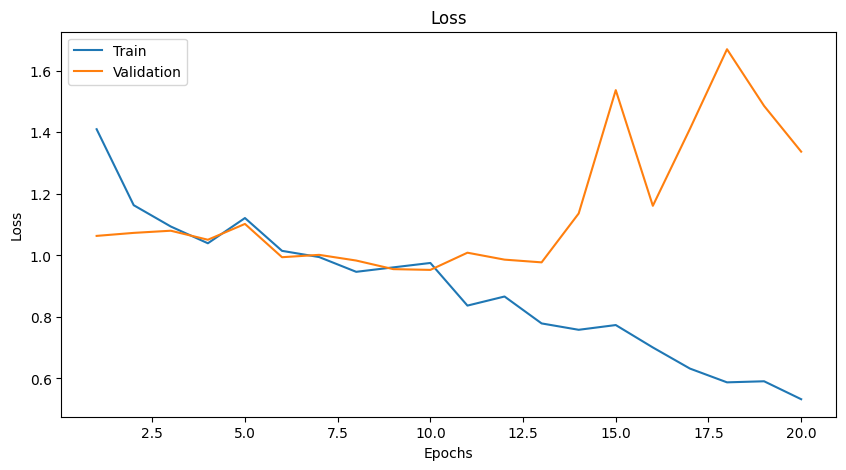

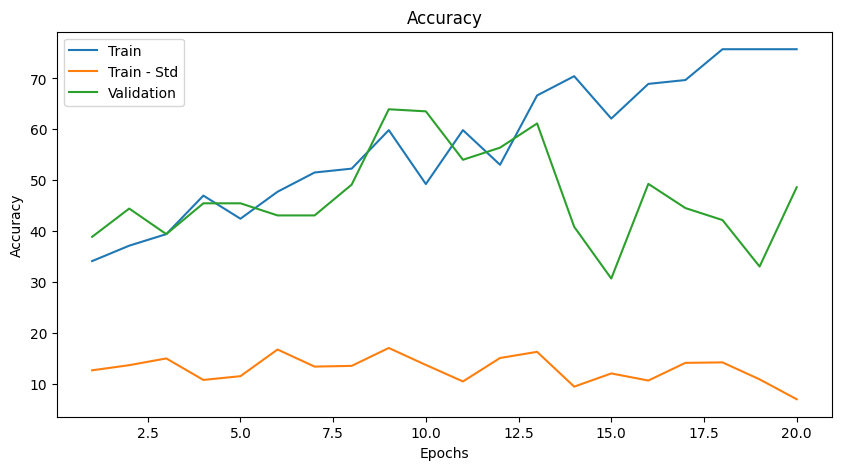

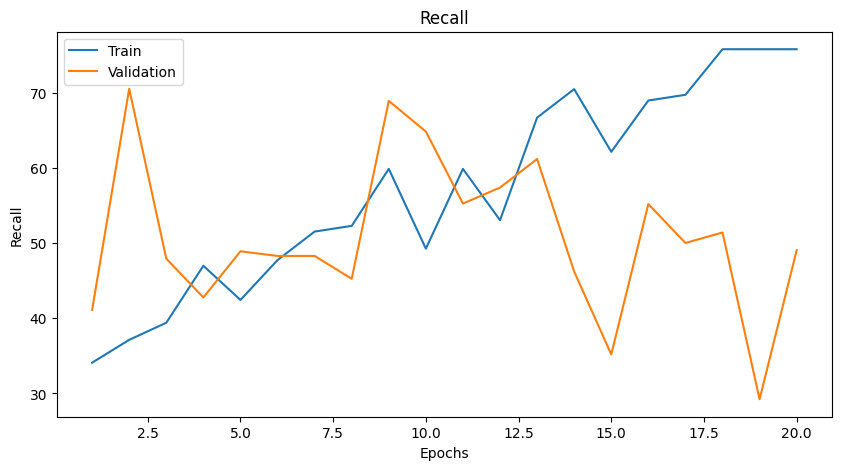

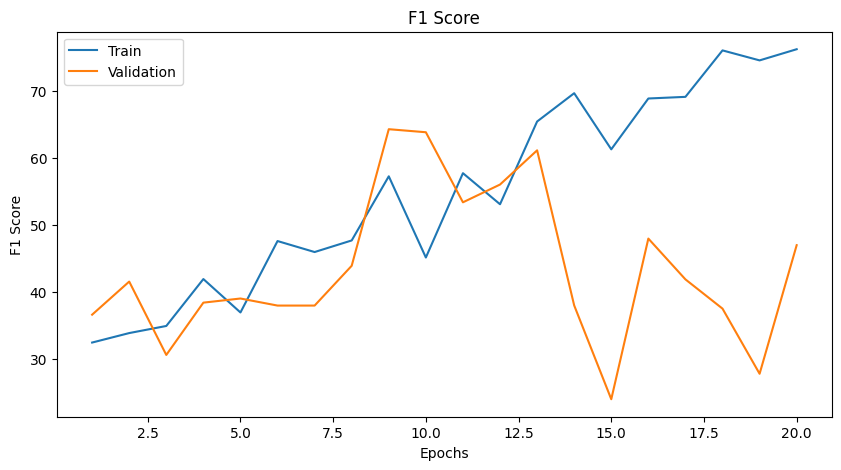

In [10]:
plot_metrics(train_losses, train_accuracies, train_accuracies_std, train_recalls, train_f1_scores,  valid_losses, valid_accuracies, valid_recalls, valid_f1_scores)

In [11]:
batch_size = 12

# Load best model saved on training
checkpoint = torch.load("output/calf_face/output_sub/best_checkpoint.pth", map_location='cpu')
model.load_state_dict(checkpoint['model'])

sampler_val = torch.utils.data.SequentialSampler(ImageDataset(valid_dataset, transform=test_transform))
valid_loader = DataLoader(dataset_val, batch_size, sampler=sampler_val, drop_last=False, collate_fn=utils.collate_fn)
test_stats = evaluate(model, criterion, valid_loader, device, args.output_dir)

Test:  [0/2]  eta: 0:00:00  loss: 1.0878 (1.0878)  time: 0.3630  data: 0.3414  max mem: 2549
Test:  [1/2]  eta: 0:00:00  loss: 0.7711 (0.9294)  time: 0.2948  data: 0.2565  max mem: 2549
Test: Total time: 0:00:00 (0.2952 s / it)
Stats: Accuracy 66.66666666666666, F1 66.46464646464646, Recall 70.83333333333334, Precision 67.85714285714285, 


In [ ]:
parser = argparse.ArgumentParser('INTR interpretation visualization script', parents=[get_args_parser()])
args = parser.parse_args(args=[])

# model, _ = build_model(args)
# model.to(device)
# model = load_model(args, model)
model.eval()

valid_dataset = ImageDataset(valid_dataset, transform=None)

valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
metric_logger = utils.MetricLogger(delimiter="  ")
header = 'Test:'
for samples, targets in metric_logger.log_every(valid_loader, 1, header):
    image = samples[0].cpu()
    samples = test_transform(samples)
    samples = samples.to(device)
    image_path = targets["file_name"][0][0]
    target_class = targets["image_label"][0][0]
    
    outputs, encoder_output, _, attention_scores, avg_attention_scores = model(samples)
    pred_class_index=predicted_bin_class(outputs, topk=(1, 1))
    print ("Species predicted by INTR is:", get_class_name(int(pred_class_index[0][0])))
    print ("Species class  is:", get_class_name(int(target_class)), "\n")

    visualization(args, image, int(pred_class_index[0][0]), attention_scores, encoder_output)
    print("-" * 30, "\n")